# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Загрузка данных

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
display(labels.head())
print("Размер выборки:", labels.shape[0])

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Размер выборки: 7591


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


### График распределения возраста

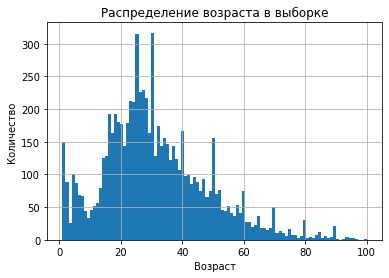

In [4]:
labels['real_age'].hist(bins=100)
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

### Печать фотографий

Found 7591 validated image filenames.


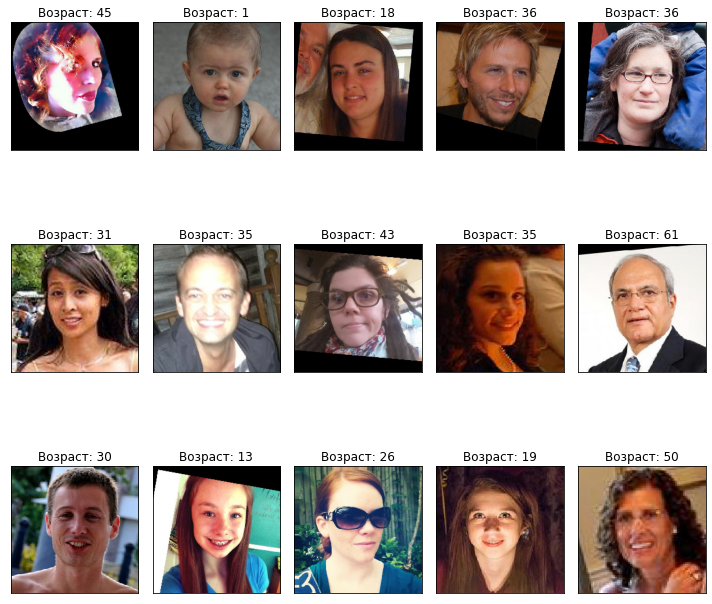

In [5]:
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=15,
    class_mode='raw'
)

features, target = next(datagen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.title('Возраст: ' + str(target[i]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

### Вывод

Исследовательский анализ данных для проекта определения возраста покупателей выявил несколько ключевых особенностей в нашем датасете:

**Размер датасета:** Датасет содержит 7591 изображение. Для задачи распознавания изображений это неплохо, особенно если мы будем использовать аугментацию, чтобы искусственно увеличить этот объем данных

**Распределение возраста:** Больше всего фотографий людей от 20 до 40 лет. Есть всплески на "круглые" даты, типа 1, 10, 20 лет. Может быть, это из-за того, что в эти возраста людей чаще фотографируют. Возможно, эти пики связаны с более частым фотографированием в эти возраста, что может создавать предвзятость в обученной модели.

**Особенности изображений:** Есть черно-белые фото, фото с посторонними предметами и сделанные под разными углами. Это может усложнить обучение модели, если мы не будем учитывать эти особенности при аугментации и предобработке.

**Рекомендованные аугментации:** Для компенсации выявленных особенностей и предотвращения переобучения, рекомендуется использовать следующие аугментации:

- Горизонтальное отражение (horizontal_flip): Эта аугментация применяется в вашем датагенераторе для обучающего набора данных (train_datagen_flow). Она полезна для увеличения разнообразия тренировочных данных и помогает модели лучше обобщать на новые данные, включая изображения, где лица повернуты в противоположные стороны.

- Изменение масштаба (rescale): Вы применяете эту аугментацию как в обучающем (train_datagen_flow), так и в валидационном (test_datagen_flow) датагенераторах. Это масштабирование пиксельных значений, обычно используемое для нормализации данных. В вашем случае оно приводит значения пикселей к диапазону от 0 до 1 (деление на 255)

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

labels = pd.read_csv('/datasets/faces/labels.csv')

optimizer = Adam(lr=0.0001)

def load_train(path):
    datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=False,
        validation_split=0.25,
        rescale=1/255.)

    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='training',
        class_mode='raw',
        seed=12345)

    return train_datagen_flow

def load_test(path):
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)

    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='validation',
        class_mode='raw',
        seed=12345)

    return test_datagen_flow

def create_model(input_shape):
    
    backbone = ResNet50(input_shape=input_shape, 
                        weights='imagenet', 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    model.compile(optimizer=optimizer, 
                loss='mean_absolute_error', 
                metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=True)

    return model

if __name__ == "__main__":
    train_data = load_train("/datasets/faces/final_files/")
    test_data = load_test("/datasets/faces/final_files/")
    model = create_model(input_shape=(224, 224, 3))
    model = train_model(model, train_data, test_data, epochs=5)
    loss, mae = model.evaluate(test_data, verbose=2)
    print("Model MAE: {:5.2f}%".format(100 * mae))

```

```
Train for 178 steps, validate for 60 steps
Epoch 1/5
178/178 - 67s - loss: 11.5551 - mae: 11.5543 - val_loss: 21.3888 - val_mae: 21.3878
Epoch 2/5
178/178 - 40s - loss: 7.1717 - mae: 7.1717 - val_loss: 15.0863 - val_mae: 15.0427
Epoch 3/5
178/178 - 40s - loss: 6.2636 - mae: 6.2639 - val_loss: 14.1797 - val_mae: 14.1581
Epoch 4/5
178/178 - 39s - loss: 5.5144 - mae: 5.5144 - val_loss: 9.8633 - val_mae: 9.8945
Epoch 5/5
178/178 - 38s - loss: 5.0868 - mae: 5.0872 - val_loss: 6.8296 - val_mae: 6.8520
60/60 - 9s - loss: 6.8296 - mae: 6.8520



## Анализ обученной модели

В ходе обучения модели на основе архитектуры ResNet50 было достигнуто постепенное снижение ошибки среднего абсолютного отклонения с 11.55 до 6.85 на валидационной выборке. По ходу обучения модель, которая строилась на базе ResNet50, стала лучше определять возраст людей по фото. Сначала она ошибалась почти на 12 лет, но к концу обучения ошибка уменьшилась до примерно 7 лет.
Итоговый результат MAE в 6.85 указывает на то, что модель достаточно хорошо справляется с поставленной задачей, особенно учитывая сложность задачи регрессии в контексте определения возраста.